!pip install pycountry

In [5]:
import requests
import pandas as pd
import pycountry
import mysql.connector as db

# ---------------------- Fetch and Process Data ----------------------

# Define WHO API dataset URLs with age group tags
datasets = {
    "https://ghoapi.azureedge.net/api/NCD_BMI_30C": "adult",
    "https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C": "child",
    "https://ghoapi.azureedge.net/api/NCD_BMI_18C": "adult",
    "https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C": "child"
}

# Rename mapping for consistency
rename_columns = {
    'TimeDim': 'Year',
    'Dim1': 'Gender',
    'NumericValue': 'Mean_Estimate',
    'Low': 'LowerBound',
    'High': 'UpperBound',
    'ParentLocation': 'Region',
    'SpatialDim': 'Country'
}
columns_to_keep = list(rename_columns.keys())

# Special cases for region/country codes
special_cases = {
    'GLOBAL': 'Global',
    'WB_LMI': 'Low & Middle Income',
    'WB_HI': 'High Income',
    'WB_LI': 'Low Income',
    'EMR': 'Eastern Mediterranean Region',
    'EUR': 'Europe',
    'AFR': 'Africa',
    'SEAR': 'South-East Asia Region',
    'WPR': 'Western Pacific Region',
    'AMR': 'Americas Region',
    'WB_UMI': 'Upper Middle Income'
}

# Convert ISO Alpha-3 to country name
def get_country_name(code):
    if code in special_cases:
        return special_cases[code]
    try:
        country = pycountry.countries.get(alpha_3=code)
        return country.name if country else code
    except:
        return code

# Store final datasets temporarily
obesity_data = []
malnutrition_data = []

# Fetch and process each dataset
for url, age_group in datasets.items():
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['value'])
        df['age_group'] = age_group  # assign age group based on dataset

        # Keep only needed columns + age_group
        df = df[[col for col in columns_to_keep if col in df.columns] + ['age_group']]
        df = df.rename(columns=rename_columns)

        # Standardize Gender values (if Gender column exists)
        if 'Gender' in df.columns:
            df['Gender'] = df['Gender'].map({
                'SEX_FMLE': 'Female',
                'SEX_MLE': 'Male',
                'SEX_BTSX': 'Both'
            }).fillna(df['Gender'])  # keep original if not mapped

        # Convert country codes to full names
        df['Country'] = df['Country'].apply(get_country_name)

        # Calculate confidence interval width
        df['CI_Width'] = df['UpperBound'] - df['LowerBound']

        # Assign nutrition levels and split datasets
        if "30C" in url or "PLUS2C" in url:
            df['obesity_level'] = df['Mean_Estimate'].apply(
                lambda x: 'High' if x >= 30 else 'Moderate' if x >= 25 else 'Low'
            )
            obesity_data.append(df)
        elif "18C" in url or "MINUS2C" in url:
            df['malnutrition_level'] = df['Mean_Estimate'].apply(
                lambda x: 'High' if x >= 20 else 'Moderate' if x >= 10 else 'Low'
            )
            malnutrition_data.append(df)
    else:
        print(f"Failed to fetch data from {url}")

# Combine into final DataFrames safely
if obesity_data:
    obesity_df = pd.concat(obesity_data, ignore_index=True)
    obesity_df = obesity_df[(obesity_df['Year'] >= 2012) & (obesity_df['Year'] <= 2022)]
else:
    print("No obesity data collected")
    obesity_df = pd.DataFrame()

if malnutrition_data:
    malnutrition_df = pd.concat(malnutrition_data, ignore_index=True)
    malnutrition_df = malnutrition_df[(malnutrition_df['Year'] >= 2012) & (malnutrition_df['Year'] <= 2022)]
else:
    print("No malnutrition data collected")
    malnutrition_df = pd.DataFrame()

### Initial Overview of the Data

#### Check the shape and the first few rows of the datasets

In [126]:
print("Obesity Data Shape:", obesity_df.shape)

Obesity Data Shape: (27720, 10)


In [3]:
print("Malnutrition Data Shape:", malnutrition_df.shape)

NameError: name 'malnutrition_df' is not defined

In [1]:
print("\nObesity Data Sample:\n", obesity_df.head())

NameError: name 'obesity_df' is not defined

In [132]:
print("\nMalnutrition Data Sample:\n", malnutrition_df.head())


Malnutrition Data Sample:
     Year    Gender  Mean_Estimate  LowerBound  UpperBound  \
1   2021  SEX_FMLE        5.79511     3.97204     8.07702   
5   2017  SEX_BTSX        3.09065     2.42823     3.84215   
6   2016  SEX_FMLE        8.37172     6.65567    10.25312   
8   2021  SEX_BTSX       13.33635    12.24232    14.44287   
10  2014   SEX_MLE        2.20807     1.25384     3.51682   

                   Region                 Country age_group  CI_Width  \
1                  Africa                   Gabon     adult   4.10498   
5         Western Pacific                Mongolia     adult   1.41392   
6                  Africa            Sierra Leone     adult   3.59745   
8                    None  South-East Asia Region     adult   2.20055   
10  Eastern Mediterranean                   Qatar     adult   2.26298   

   malnutrition_level  
1                 Low  
5                 Low  
6                 Low  
8            Moderate  
10                Low  


#### Summary Statistics

In [134]:
print("\nObesity Data Summary:\n", obesity_df.describe())


Obesity Data Summary:
                Year  Mean_Estimate    LowerBound    UpperBound      CI_Width
count  27720.000000   27720.000000  27720.000000  27720.000000  27720.000000
mean    2017.000000      12.761041      9.393155     17.068489      7.675334
std        3.162335      10.858925      9.893854     12.395013      6.616899
min     2012.000000       0.265670      0.077540      0.547850      0.216700
25%     2014.000000       4.753960      2.354430      7.875503      2.926715
50%     2017.000000       9.944540      6.506535     13.704380      5.480535
75%     2020.000000      17.482418     12.697755     23.986050     10.338880
max     2022.000000      80.609250     74.365370     87.868510     40.554060


In [63]:
print("\nMalnutrition Data Summary:\n", malnutrition_df.describe())


Malnutrition Data Summary:
                Year  Mean_Estimate    LowerBound    UpperBound      CI_Width
count  83160.000000   83160.000000  83160.000000  83160.000000  83160.000000
mean    2006.000000       6.180179      3.992293      9.201463      5.209170
std        9.521962       5.926806      4.856064      7.684302      4.724336
min     1990.000000       0.175310      0.023700      0.354830      0.165840
25%     1998.000000       2.126213      1.094330      3.364553      1.737168
50%     2006.000000       3.954130      2.104835      6.682355      3.661350
75%     2014.000000       8.490842      5.074133     12.934138      7.207653
max     2022.000000      49.734490     44.648730     54.839160     32.000760


### Checking for Missing or Unusual Values

In [68]:
# Checking for missing values

In [136]:
print("\nMissing Values in Obesity Data:", obesity_df.isnull().sum())


Missing Values in Obesity Data: Year                0
Gender              0
Mean_Estimate       0
LowerBound          0
UpperBound          0
Region           1452
Country             0
age_group           0
CI_Width            0
obesity_level       0
dtype: int64


In [138]:
print("\nMissing Values in Malnutrition Data:", malnutrition_df.isnull().sum())


Missing Values in Malnutrition Data: Year                     0
Gender                   0
Mean_Estimate            0
LowerBound               0
UpperBound               0
Region                1452
Country                  0
age_group                0
CI_Width                 0
malnutrition_level       0
dtype: int64


In [74]:
#Check for unique values in key columns (eg : Gender, Region, Country)

In [140]:
print("\nUnique Values in Gender (Obesity):", obesity_df['Gender'].unique())


Unique Values in Gender (Obesity): ['SEX_MLE' 'SEX_FMLE' 'SEX_BTSX']


In [142]:
print("\nUnique Values in Region (Obesity):", obesity_df['Region'].unique())


Unique Values in Region (Obesity): ['Eastern Mediterranean' 'Europe' 'Americas' 'South-East Asia' 'Africa'
 'Western Pacific' None]


In [144]:
print("\nUnique Values in Gender (Malnutrition):", malnutrition_df['Gender'].unique())


Unique Values in Gender (Malnutrition): ['SEX_FMLE' 'SEX_BTSX' 'SEX_MLE']


In [146]:
print("\nUnique Values in Region (Malnutrition):", malnutrition_df['Region'].unique())


Unique Values in Region (Malnutrition): ['Africa' 'Western Pacific' None 'Eastern Mediterranean' 'Europe'
 'Americas' 'South-East Asia']


### Checking Distribution of Key Columns

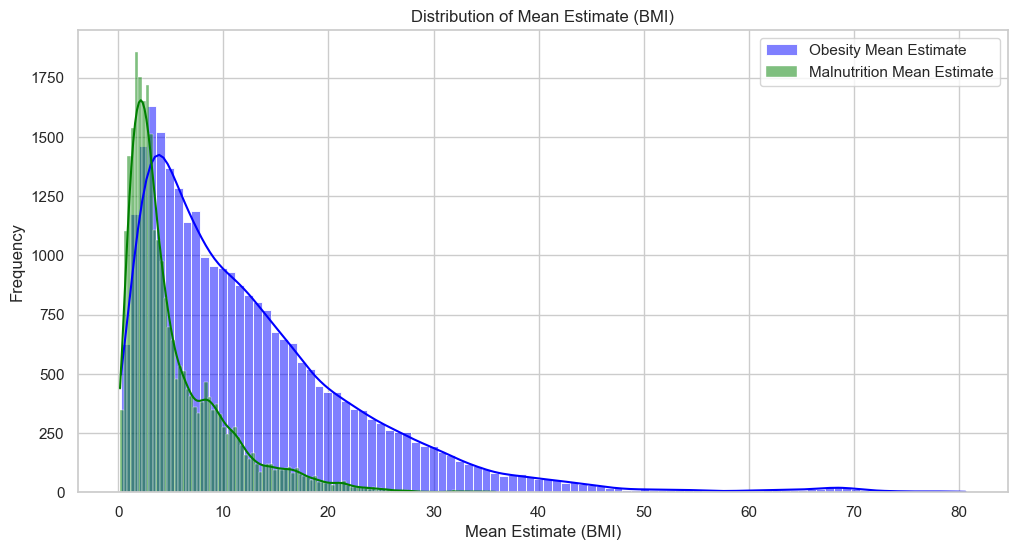

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Plot distributions of Mean_Estimate
plt.figure(figsize=(12, 6))
sns.histplot(obesity_df['Mean_Estimate'], kde=True, color='blue', label="Obesity Mean Estimate")
sns.histplot(malnutrition_df['Mean_Estimate'], kde=True, color='green', label="Malnutrition Mean Estimate")
plt.title("Distribution of Mean Estimate (BMI)")
plt.xlabel("Mean Estimate (BMI)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

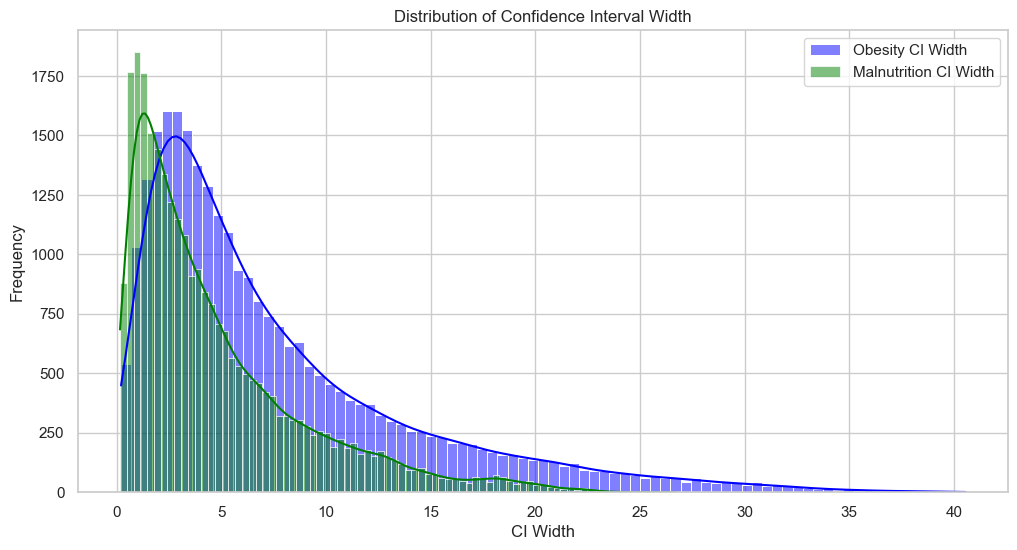

In [150]:
plt.figure(figsize=(12, 6))
sns.histplot(obesity_df['CI_Width'], kde=True, color='blue', label="Obesity CI Width")
sns.histplot(malnutrition_df['CI_Width'], kde=True, color='green', label="Malnutrition CI Width")
plt.title("Distribution of Confidence Interval Width")
plt.xlabel("CI Width")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Analyzing Trends Across Years, Regions, or Demographic Groups

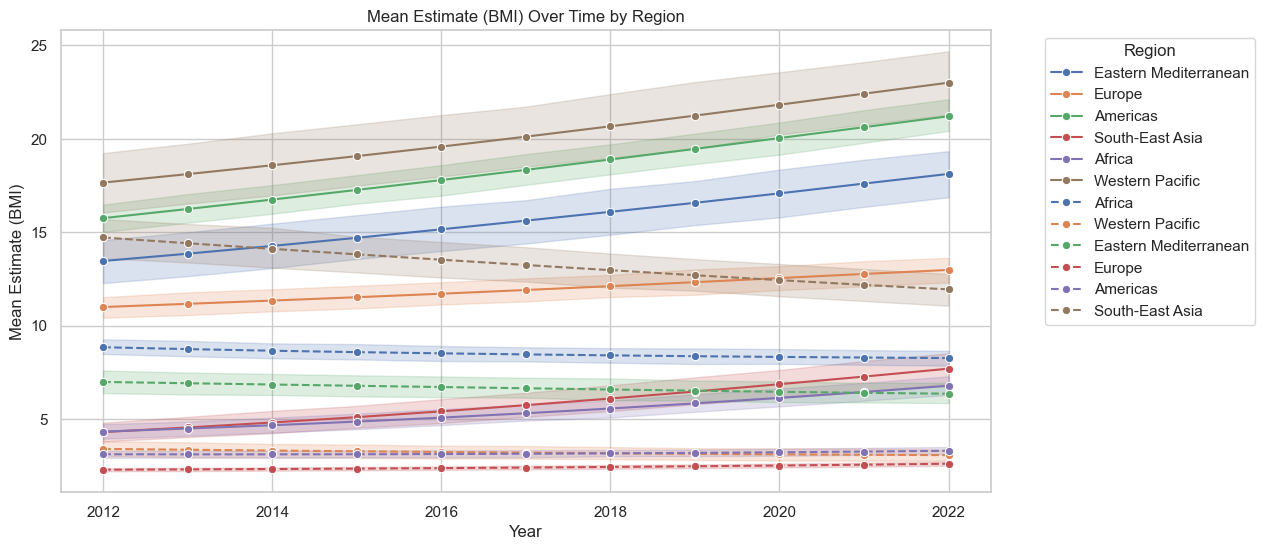

In [155]:
# Line plot for trend over years for both obesity and malnutrition datasets
plt.figure(figsize=(12, 6))
sns.lineplot(data=obesity_df, x="Year", y="Mean_Estimate", hue="Region", marker='o')
sns.lineplot(data=malnutrition_df, x="Year", y="Mean_Estimate", hue="Region", marker='o', linestyle='--')
plt.title("Mean Estimate (BMI) Over Time by Region")
plt.xlabel("Year")
plt.ylabel("Mean Estimate (BMI)")
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_9620\639973172.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




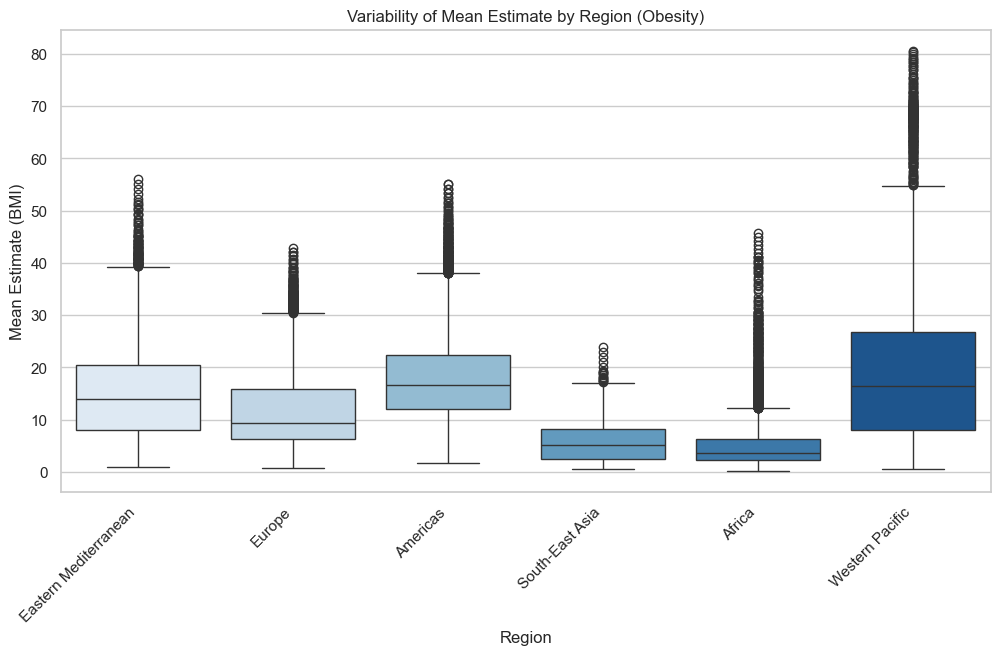

In [156]:
# Boxplot for variability of Mean_Estimate by Region
plt.figure(figsize=(12, 6))
sns.boxplot(data=obesity_df, x="Region", y="Mean_Estimate", palette="Blues")
plt.title("Variability of Mean Estimate by Region (Obesity)")
plt.xlabel("Region")
plt.ylabel("Mean Estimate (BMI)")
plt.xticks(rotation=45, ha="right")
plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_9620\456592279.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=malnutrition_df, x="Region", y="Mean_Estimate", palette="Greens")


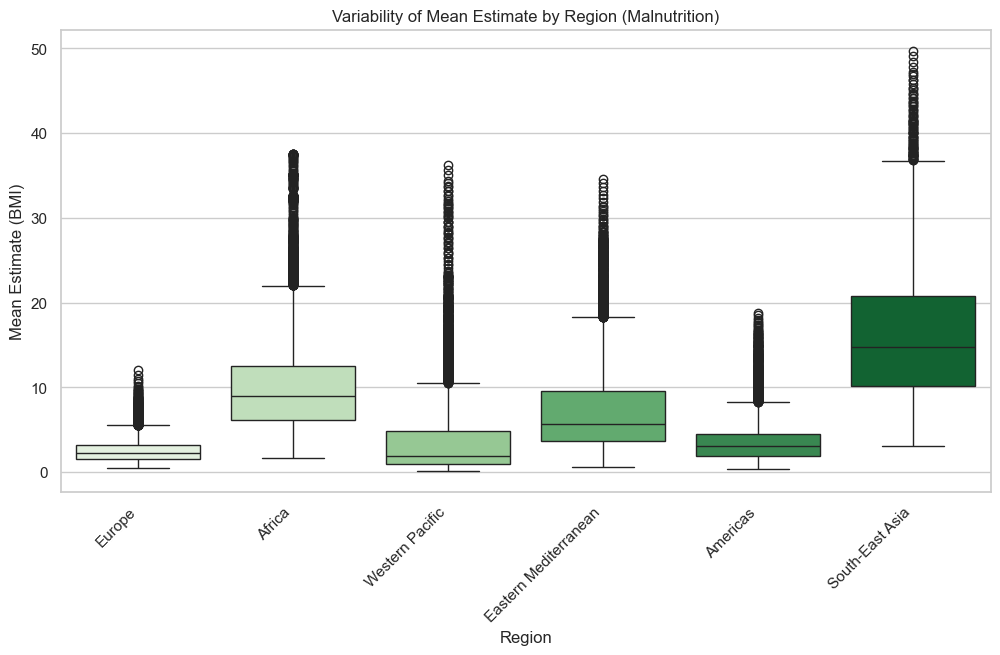

In [96]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=malnutrition_df, x="Region", y="Mean_Estimate", palette="Greens")
plt.title("Variability of Mean Estimate by Region (Malnutrition)")
plt.xlabel("Region")
plt.ylabel("Mean Estimate (BMI)")
plt.xticks(rotation=45, ha="right")
plt.show()

### Comparing Obesity vs. Malnutrition Distributions

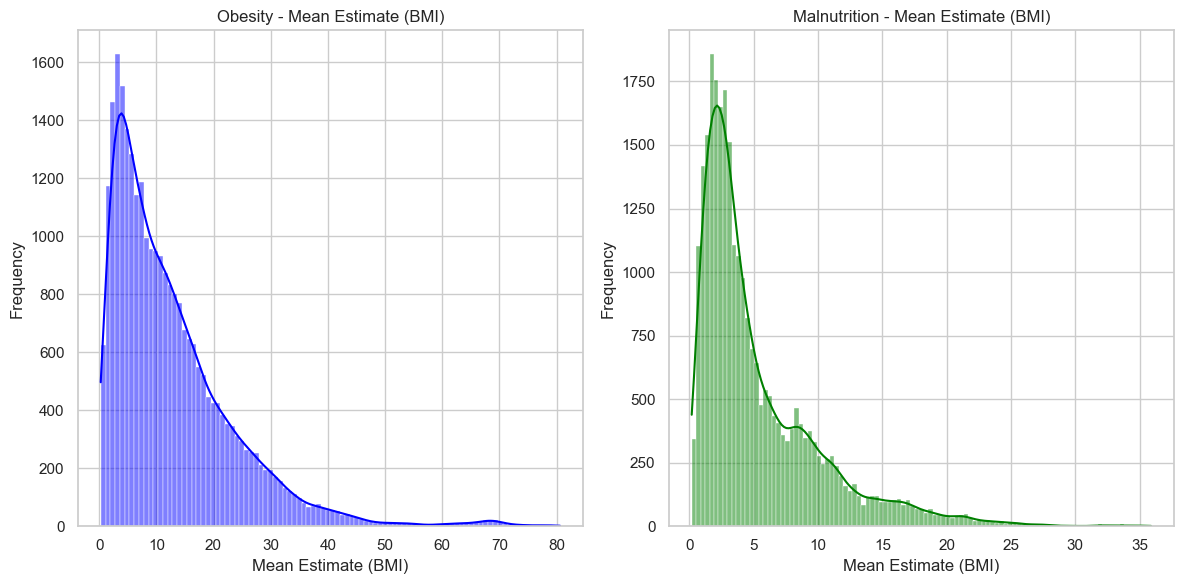

In [157]:
# Side-by-side comparison of distributions of obesity and malnutrition
plt.figure(figsize=(12, 6))

# Obesity distribution
plt.subplot(1, 2, 1)
sns.histplot(obesity_df['Mean_Estimate'], kde=True, color='blue')
plt.title("Obesity - Mean Estimate (BMI)")
plt.xlabel("Mean Estimate (BMI)")
plt.ylabel("Frequency")

# Malnutrition distribution
plt.subplot(1, 2, 2)
sns.histplot(malnutrition_df['Mean_Estimate'], kde=True, color='green')
plt.title("Malnutrition - Mean Estimate (BMI)")
plt.xlabel("Mean Estimate (BMI)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Heatmaps or Scatter Plots to Identify Patterns and Outliers

In [104]:
#Heatmap for Correlation Matrix:

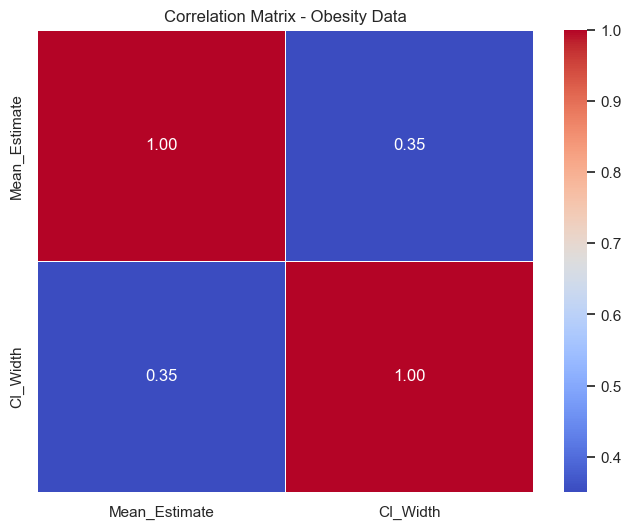

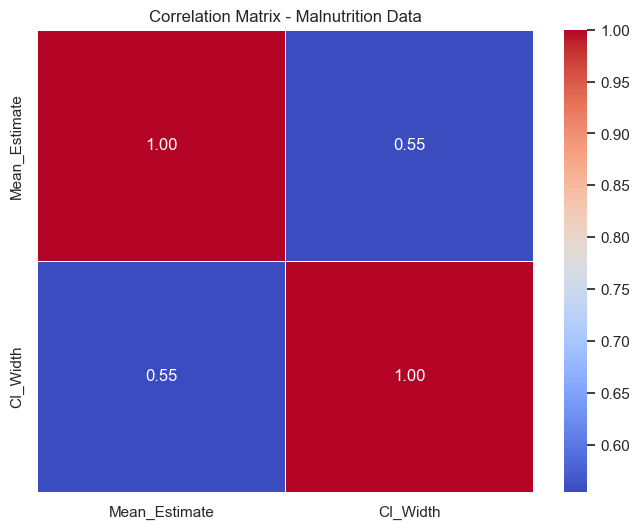

In [160]:
# Correlation matrix for Obesity Data
corr_obesity = obesity_df[['Mean_Estimate', 'CI_Width']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_obesity, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix - Obesity Data")
plt.show()

# Correlation matrix for Malnutrition Data
corr_malnutrition = malnutrition_df[['Mean_Estimate', 'CI_Width']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_malnutrition, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix - Malnutrition Data")
plt.show()


In [106]:
# Scatter Plot to Identify Patterns:

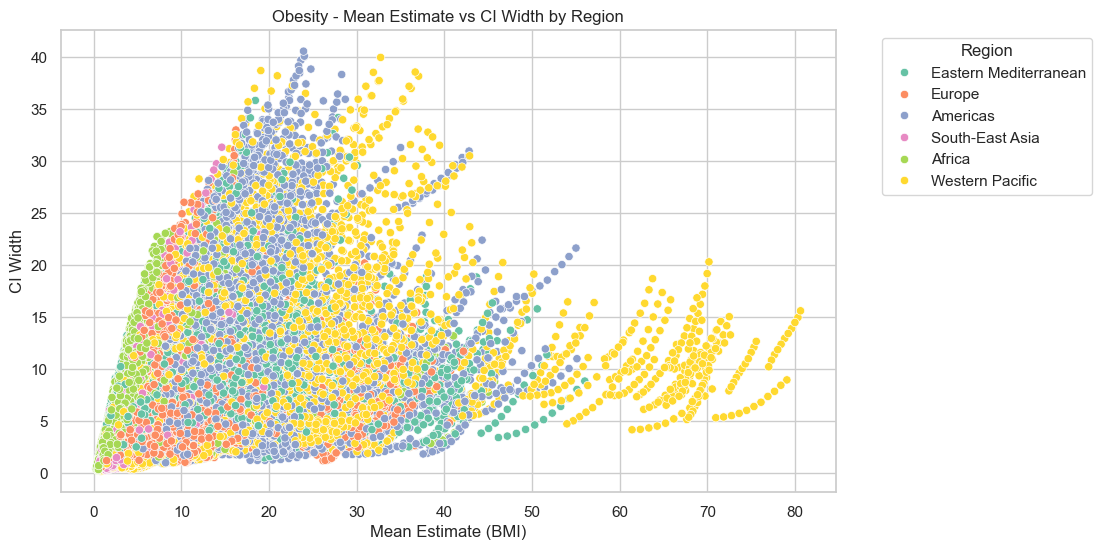

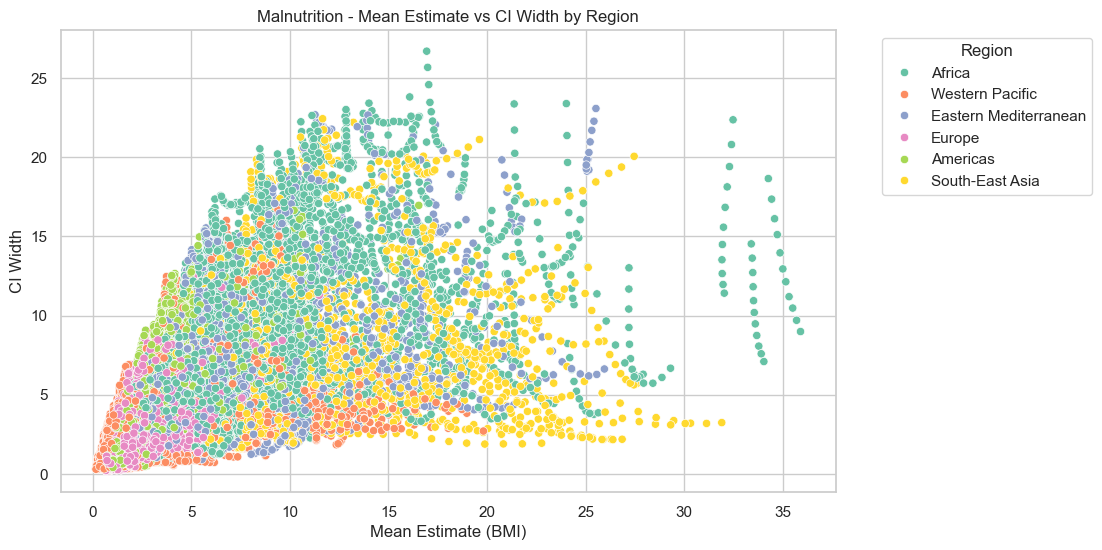

In [163]:
# Scatter plot to see the relationship between Mean Estimate and CI Width for obesity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=obesity_df, x="Mean_Estimate", y="CI_Width", hue="Region", palette="Set2")
plt.title("Obesity - Mean Estimate vs CI Width by Region")
plt.xlabel("Mean Estimate (BMI)")
plt.ylabel("CI Width")
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Scatter plot to see the relationship between Mean Estimate and CI Width for malnutrition
plt.figure(figsize=(10, 6))
sns.scatterplot(data=malnutrition_df, x="Mean_Estimate", y="CI_Width", hue="Region", palette="Set2")
plt.title("Malnutrition - Mean Estimate vs CI Width by Region")
plt.xlabel("Mean Estimate (BMI)")
plt.ylabel("CI Width")
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Interactive Plotting with Plotly 

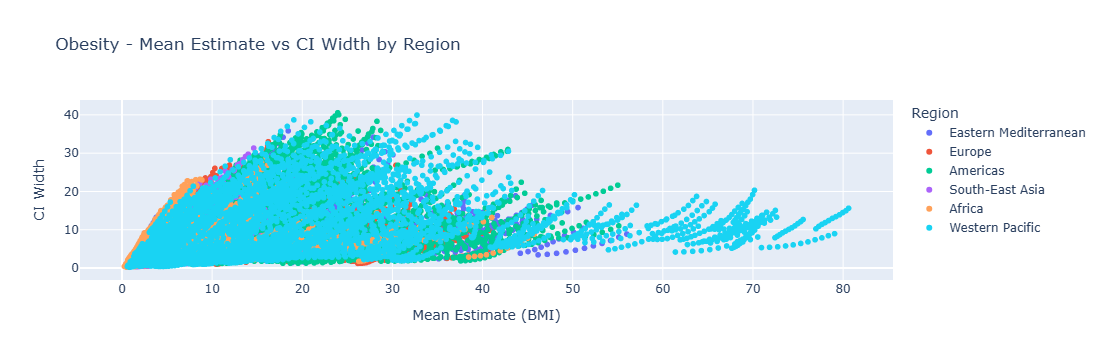

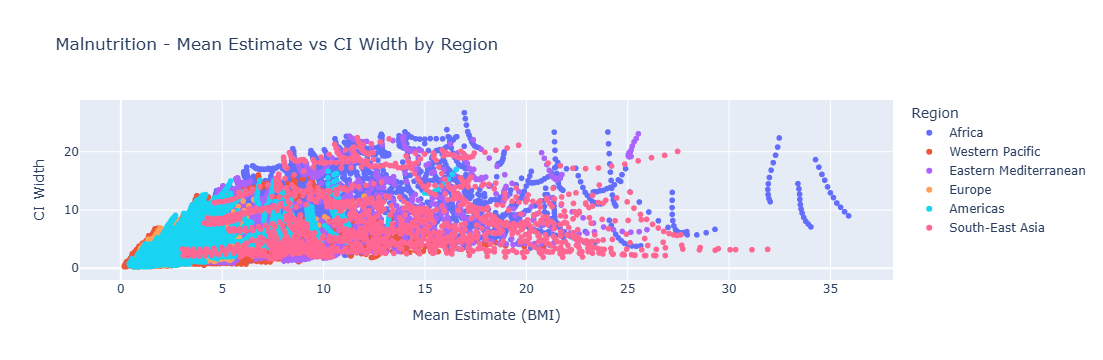

In [165]:
import plotly.express as px

# Interactive Scatter plot for Obesity
fig = px.scatter(obesity_df, x="Mean_Estimate", y="CI_Width", color="Region", 
                 title="Obesity - Mean Estimate vs CI Width by Region",
                 labels={"Mean_Estimate": "Mean Estimate (BMI)", "CI_Width": "CI Width"})
fig.show()

# Interactive Scatter plot for Malnutrition
fig = px.scatter(malnutrition_df, x="Mean_Estimate", y="CI_Width", color="Region", 
                 title="Malnutrition - Mean Estimate vs CI Width by Region",
                 labels={"Mean_Estimate": "Mean Estimate (BMI)", "CI_Width": "CI Width"})
fig.show()


In [7]:
connection = db.connect(
    host='localhost',
    user='root',
    password='Anbu_0820',
    database='ds'
)
cur = connection.cursor()

# Drop existing tables (optional, be careful!)
cur.execute("DROP TABLE IF EXISTS obesity;")
cur.execute("DROP TABLE IF EXISTS malnutrition;")

# Create obesity table
create_obesity_table = """
CREATE TABLE obesity (
    id INT AUTO_INCREMENT PRIMARY KEY,
    Year INT,
    Gender VARCHAR(10),
    Mean_Estimate FLOAT,
    LowerBound FLOAT,
    UpperBound FLOAT,
    age_group VARCHAR(50),
    Region VARCHAR(255),
    Country VARCHAR(255),
    CI_Width FLOAT,
    obesity_level VARCHAR(20)
);
"""
cur.execute(create_obesity_table)

# Create malnutrition table
create_malnutrition_table = """
CREATE TABLE malnutrition (
    id INT AUTO_INCREMENT PRIMARY KEY,
    Year INT,
    Gender VARCHAR(10),
    Mean_Estimate FLOAT,
    LowerBound FLOAT,
    UpperBound FLOAT,
    age_group VARCHAR(50),
    Region VARCHAR(255),
    Country VARCHAR(255),
    CI_Width FLOAT,
    malnutrition_level VARCHAR(20)
);
"""
cur.execute(create_malnutrition_table)
connection.commit()

# Insert obesity data if exists
if not obesity_df.empty:
    insert_obesity_query = """
    INSERT INTO obesity (Year, Gender, Mean_Estimate, LowerBound, UpperBound, age_group, Region, Country, CI_Width, obesity_level)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """
    for _, row in obesity_df.iterrows():
        cur.execute(insert_obesity_query, (
            row['Year'], row['Gender'], row['Mean_Estimate'], row['LowerBound'], row['UpperBound'],
            row['age_group'], row['Region'], row['Country'], row['CI_Width'], row['obesity_level']
        ))
    connection.commit()
else:
    print("No obesity data to insert")

# Insert malnutrition data if exists
if not malnutrition_df.empty:
    insert_malnutrition_query = """
    INSERT INTO malnutrition (Year, Gender, Mean_Estimate, LowerBound, UpperBound, age_group, Region, Country, CI_Width, malnutrition_level)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """
    for _, row in malnutrition_df.iterrows():
        cur.execute(insert_malnutrition_query, (
            row['Year'], row['Gender'], row['Mean_Estimate'], row['LowerBound'], row['UpperBound'],
            row['age_group'], row['Region'], row['Country'], row['CI_Width'], row['malnutrition_level']
        ))
    connection.commit()
else:
    print("No malnutrition data to insert")

In [11]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [13]:
connection = db.connect(
    host='localhost',
    user='root',
    password='Anbu_0820',
    database='ds'
)
cur = connection.cursor()